In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import pickle
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Shape: (4815, 9)
       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0

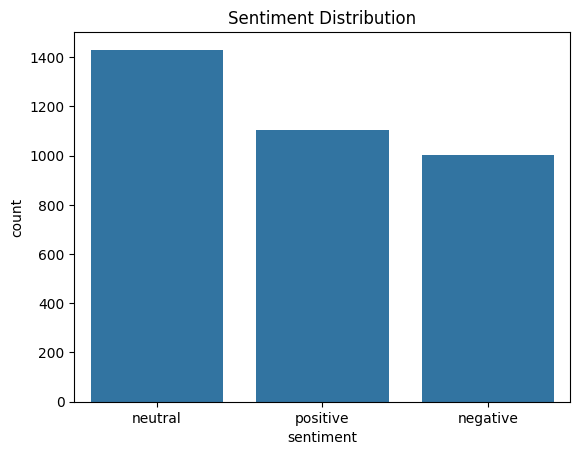

In [6]:
df = pd.read_csv("/content/sentiment.csv", encoding='ISO-8859-1')

print("Shape:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Sentiment distribution
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


In [13]:
!pip install emoji
!pip install contractions
import emoji
import contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.1 MB/s eta 0:00:00


In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = contractions.fix(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].astype(str).apply(clean_text)


In [17]:
print(df['sentiment'].unique())

['neutral' 'positive' 'negative' nan]


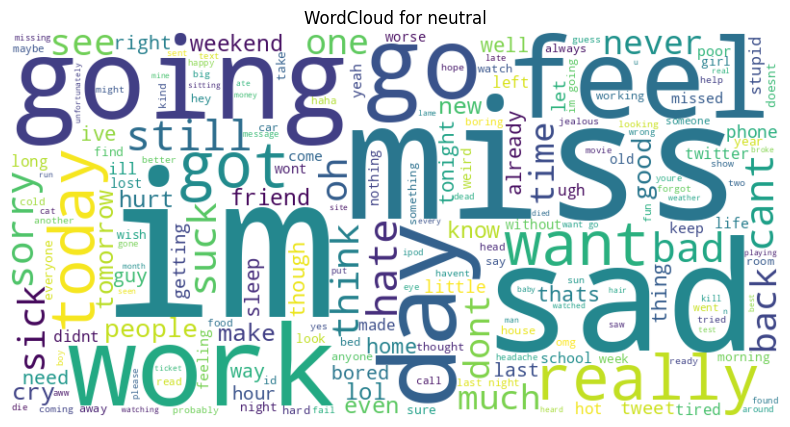

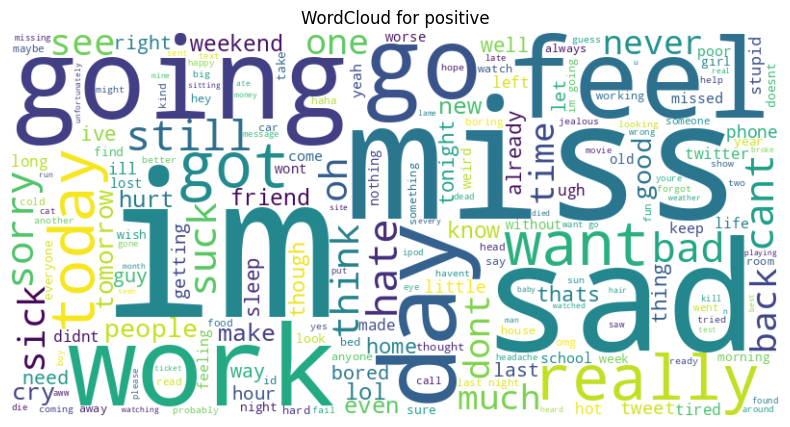

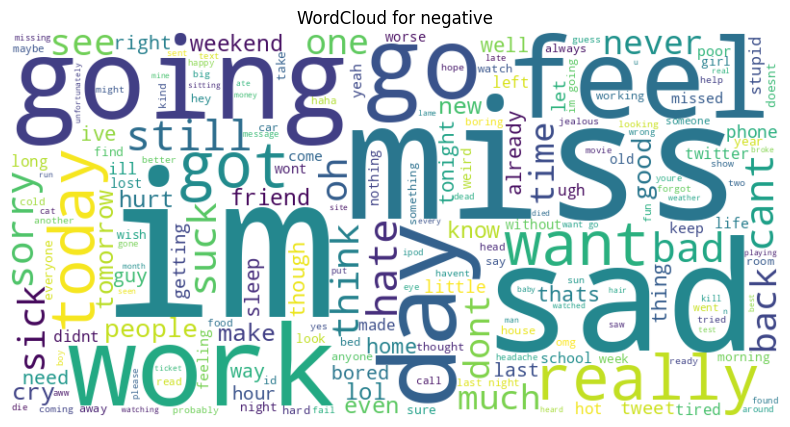

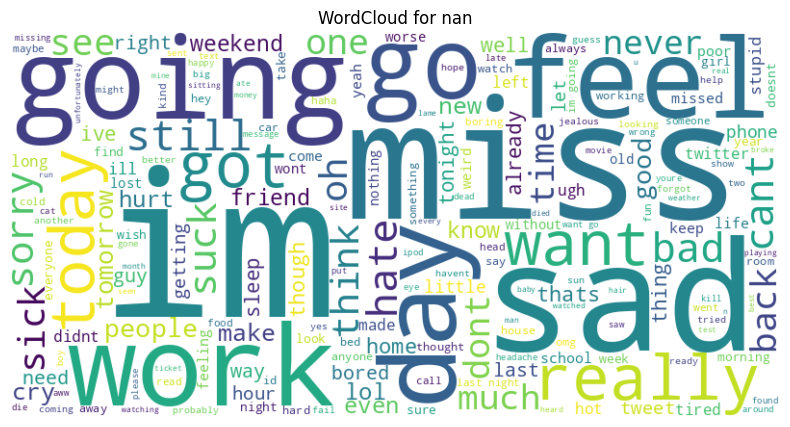

In [19]:
sentiments = df['sentiment'].unique()
for sentiment in sentiments:
    text = " ".join(df[df['sentiment'] == sentiment]['clean_text'])

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for {sentiment}")
    plt.axis('off')
    plt.show()


In [20]:
df['label'] = df['sentiment'].astype('category').cat.codes
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [22]:
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train_vec, y_train)

svm_model = SVC(probability=True)
svm_model.fit(X_train_vec, y_train)


SVC(probability=True)

Accuracy: 0.7217030114226376
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       258
           0       0.75      0.46      0.57       226
           1       0.53      0.74      0.62       268
           2       0.70      0.65      0.67       211

    accuracy                           0.72       963
   macro avg       0.75      0.71      0.71       963
weighted avg       0.74      0.72      0.72       963



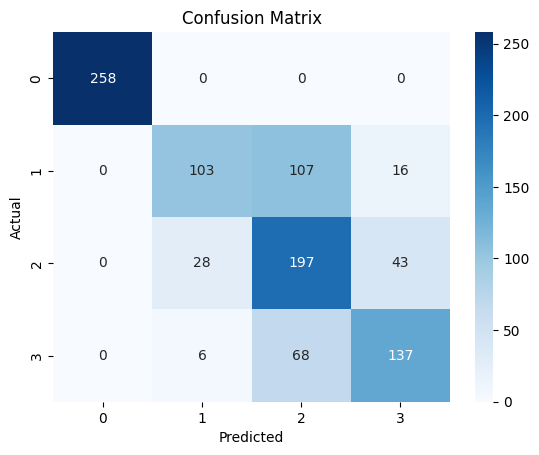

Accuracy: 0.7206645898234684
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       258
           0       0.84      0.36      0.50       226
           1       0.52      0.86      0.65       268
           2       0.77      0.59      0.67       211

    accuracy                           0.72       963
   macro avg       0.78      0.70      0.70       963
weighted avg       0.78      0.72      0.71       963



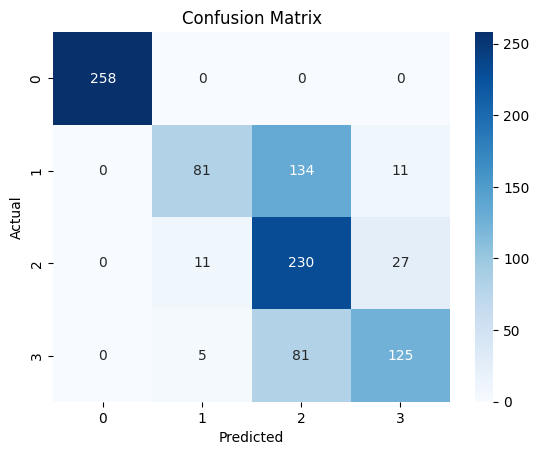

In [23]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate(log_model, X_test_vec, y_test)
evaluate(svm_model, X_test_vec, y_test)


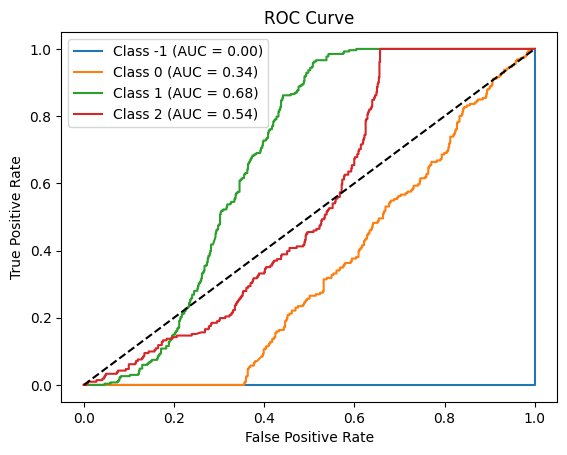

In [24]:
y_score = log_model.predict_proba(X_test_vec)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in np.unique(y_test):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()


In [25]:
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_model, f)
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)


In [26]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred = log_model.predict(vec)
    label = df['sentiment'].astype('category').cat.categories[pred[0]]
    return label

sample_text = "I love this so much! Best experience ever!"
print("Predicted Sentiment:", predict_sentiment(sample_text))


Predicted Sentiment: positive


In [27]:
from sklearn.model_selection import cross_val_score

log_scores = cross_val_score(log_model, X_train_vec, y_train, cv=5)
svm_scores = cross_val_score(svm_model, X_train_vec, y_train, cv=5)

print("Logistic Regression CV Accuracy:", np.mean(log_scores))
print("SVM CV Accuracy:", np.mean(svm_scores))


Logistic Regression CV Accuracy: 0.7128761770006906
SVM CV Accuracy: 0.6952276517257062


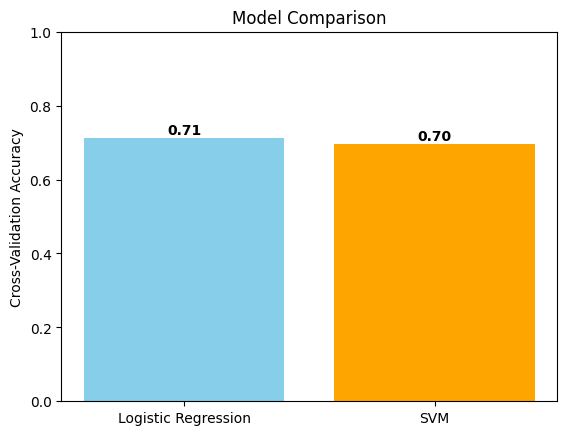

In [28]:
models = ['Logistic Regression', 'SVM']
scores = [np.mean(log_scores), np.mean(svm_scores)]

plt.bar(models, scores, color=['skyblue', 'orange'])
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


In [29]:
def show_most_informative_features(vectorizer, model, n=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_positive = np.argsort(coefs)[-n:]
    top_negative = np.argsort(coefs)[:n]
    print("Top Positive Words:")
    print(feature_names[top_positive])
    print("Top Negative Words:")
    print(feature_names[top_negative])

show_most_informative_features(tfidf, log_model)


Top Positive Words:
['good sucking' 'every mom' 'fun today' 'denmark love' 'come denmark'
 'denmark' 'goddamit' 'goddamit guh' 'glad enjoy' 'familia' 'example'
 'day tell' 'example archuleta' 'celebrate woo' 'day mama' 'crane created'
 'created' 'friend reduces' 'created series' 'nan']
Top Negative Words:
['im' 'day' 'good' 'like' 'going' 'got' 'go' 'know' 'get' 'work' 'want'
 'today' 'one' 'time' 'back' 'love' 'oh' 'think' 'well' 'happy']


In [30]:
y_pred = log_model.predict(X_test_vec)
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total Misclassifications: {len(misclassified_indices)}")

# Show a few misclassified examples
for i in misclassified_indices[:5]:
    print(f"\nText: {X_test.iloc[i]}")
    print(f"Actual: {df['sentiment'].astype('category').cat.categories[y_test.iloc[i]]}")
    print(f"Predicted: {df['sentiment'].astype('category').cat.categories[y_pred[i]]}")


Total Misclassifications: 268

Text: screw fact cant post long update twitter
Actual: negative
Predicted: neutral

Text: got freakin macbook hoorayyy freakin deleted phootbooth
Actual: neutral
Predicted: negative

Text: dammit need new cupcake tin
Actual: negative
Predicted: neutral

Text: younger sister fly next week two week visit blessed look forward seeing family member visit
Actual: neutral
Predicted: positive

Text: nigs wont get thisnot without check lmfao
Actual: negative
Predicted: neutral


In [31]:
misclassified_df = pd.DataFrame({
    "text": X_test.iloc[misclassified_indices],
    "actual": y_test.iloc[misclassified_indices].map(lambda x: df['sentiment'].astype('category').cat.categories[x]),
    "predicted": y_pred[misclassified_indices].astype(int)
})
misclassified_df['predicted'] = misclassified_df['predicted'].map(lambda x: df['sentiment'].astype('category').cat.categories[x])
misclassified_df.to_csv("misclassified_samples.csv", index=False)
print("Saved misclassified samples to 'misclassified_samples.csv'")


Saved misclassified samples to 'misclassified_samples.csv'


In [32]:
import joblib

joblib.dump(log_model, "logistic_model.joblib")
joblib.dump(svm_model, "svm_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Models and vectorizer saved.")


Models and vectorizer saved.
